# Improving Below Ground Salt Identification

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf

# from tqdm import tqdm_notebook, tnrange
# from itertools import chain
# from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
# from skimage.morphology import label # Why doesn't this important work for me? - Brandt

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras import backend as K

# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing.image import load_img

from pathlib import Path
from sklearn.model_selection import train_test_split

#tf.cast(my_tensor, tf.int32) 
# warnings.filterwarnings("ignore")

First, we need to specifiy the file paths to our data:

In [2]:
#path_data = Path() / 'competition_data' # Root data folder
path_test_images =  './test/images/' # Directory containing the test images
path_train_images = './train/images/' # Directory containing the training images
path_train_masks = './train/masks/' # Directory containing the training masks

Load the raw data csv files and clean them up a bit:

In [3]:
# 'Depths.csv' contains all of the image ids - train and test -  along with the depth where the image was taken 
depth_data = pd.read_csv('depths.csv', index_col='id')
depth_data.columns = ['depth'] # Rename the column 'z' to 'depth' so its easier to understand

# 'train.csv' contains all of the image ids in the training set
# It also contains another column called 'rle_mask' which isn't very useful, so we convert it to a new variable to indicate if there is salt in the image
train_data = pd.read_csv('train.csv', index_col='id')
train_data['contains_salt'] = ~train_data['rle_mask'].isna()
train_data.drop(columns='rle_mask',inplace=True)

# Merge all of the info together so that we now have training and test data frames
train_df = train_data.merge(depth_data,left_index=True, right_index=True)
test_df = depth_data[~depth_data.index.isin(train_df.index)]

train_df.head()

,contains_salt,depth
id,,
2c45b152f1,True,312
3cb59a4fdc,True,603
e185ab5dc1,True,687
c78c89577c,True,236
6306dd3a8e,True,805


We create some helper functions for working with the images:

Note: I think we have to return this as a 3d array because thats how the convolutions expect it to be. Not positive tho

In [4]:
def get_img_by_id(id:str, as_array:bool=True):
    """Returns a 101 x 101 numpy array of the image by default. If 'as_array' = False then it will return an image pillow object"""
    if id in train_df.index:
        img =  load_img(path_train_images + id + '.png')
    elif id in test_df.index:
        img = load_img(path_test_images + id +  '.png')
    else:
        raise Exception(f'"{id}" is not a valid id you goon!!!')

    if as_array:
        # Return the image as a 3d array with one channel. We don't need the 2&3 channels because this is a grayscale image and they are identical
        return np.array(img)[:,:,:1]
    else:
        return img


def get_mask_by_id(id:str, as_array:bool=True):
    """Same as above, just with the masks of training images"""
    img = load_img(path_train_masks + id + '.png')
    if as_array:
        # Return the image as a 2d array. We don't need the 2&3 channels because this is a grayscale image and they are identical
        return np.array(img)[:,:,:1]
    else:
        return img

In [5]:
#get_img_by_id(train_df.index[0])

Now we can visualize a few examples from the training set. Below is displayed several example seismic images, with their accompanying salt idenfitification masks placed adjacent. 

### Put Masks side by side instead of on top??

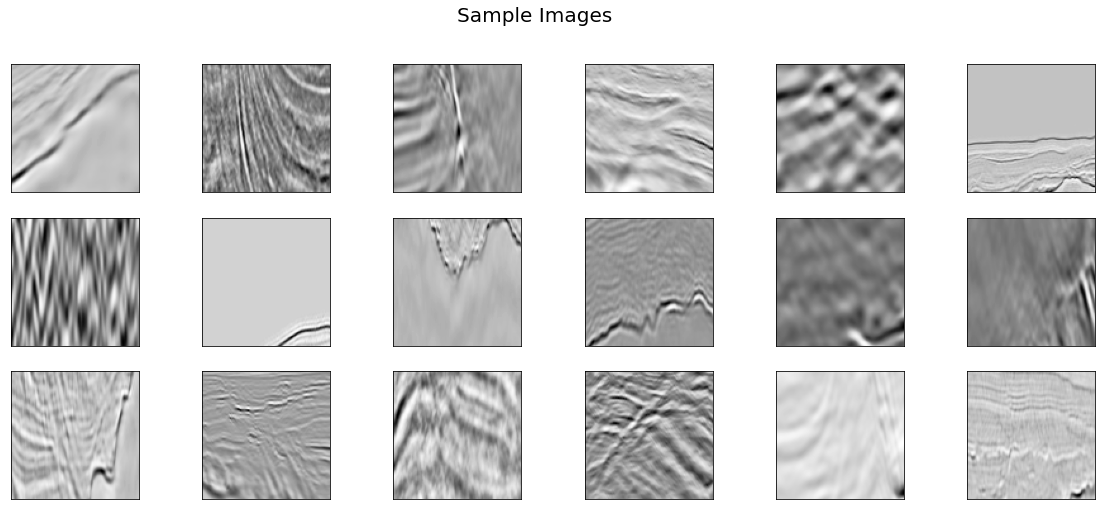

In [6]:
imgs_to_show = 18
num_rows = 3; num_cols = 6
sample_training_ids = train_df.index[:imgs_to_show]

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols,  figsize=(20,8))

for i, img_id in enumerate(sample_training_ids):
    # Get the correct axis based on how many total rows and columns are in the figure and the current index
    ax = axs[int(i/num_cols), i % num_cols] 
    ax.imshow(get_img_by_id(img_id),cmap='Greys')
#     ax.imshow(get_mask_by_id(img_id),alpha=.35,cmap='Purples')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    # ax.title.set_text(f'{img_id}')

plt.suptitle('Sample Images',fontsize=20);

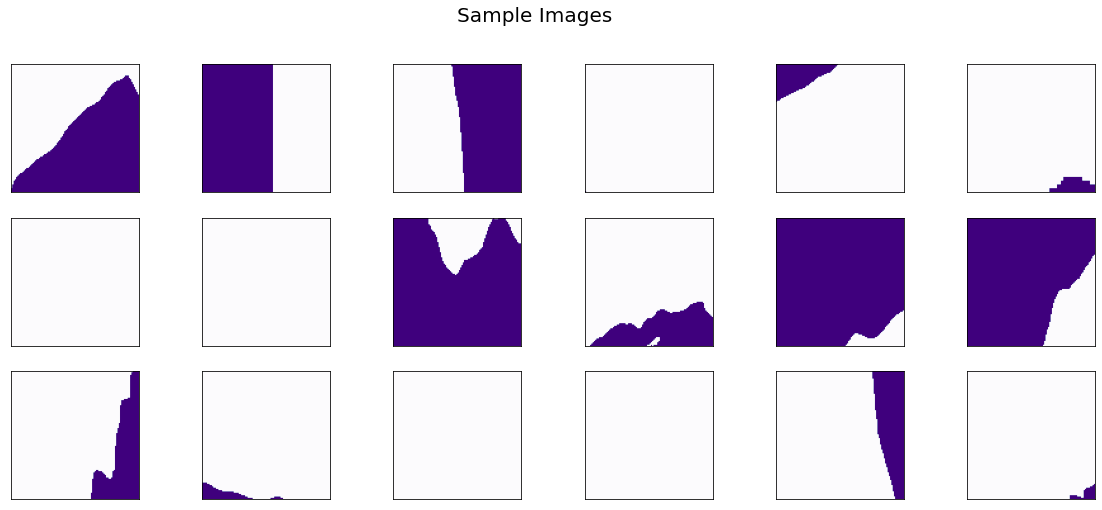

In [7]:
imgs_to_show = 18
num_rows = 3; num_cols = 6
sample_training_ids = train_df.index[:imgs_to_show]

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols,  figsize=(20,8))

for i, img_id in enumerate(sample_training_ids):
    # Get the correct axis based on how many total rows and columns are in the figure and the current index
    ax = axs[int(i/num_cols), i % num_cols] 
#     ax.imshow(get_img_by_id(img_id),cmap='Greys')
    ax.imshow(get_mask_by_id(img_id),cmap='Purples')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    # ax.title.set_text(f'{img_id}')

plt.suptitle('Sample Images',fontsize=20);

## Prepare Data for Model

In [8]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
img_size_needed = 128

Load in all of the images and their masks as numpy arrays:

In [10]:
X_all = np.array([get_img_by_id(id) for id in train_df.index])
Y_all = np.array([get_mask_by_id(id) for id in train_df.index])

Messy cell below,  but it's vectorized for performance purposes

Notes:
* Explain why np. floor and converting to bool

In [11]:
X_all_resized = np.array([np.floor(resize(img, (img_size_needed, img_size_needed, 1), mode='constant', preserve_range=True)) for img in X_all])
Y_all_resized = np.array([np.array(resize(img, (img_size_needed, img_size_needed, 1), mode='constant', preserve_range=True),dtype=bool) for img in Y_all])

Split the training into train and validaiton sets.

In [12]:
X_train, X_test, Y_train, Y_test  = train_test_split(X_all_resized, Y_all_resized,train_size=3500, random_state=42)

Now add in some extra training images by flipping, and rotating the training set. Shuffle again just because. 

In [13]:
X_ud_flipped = [np.flipud(img) for img in X_train]
X_lr_flipped = [np.fliplr(img) for img in X_train]
X_rotated = [np.rot90(img) for img in X_train]

Y_ud_flipped = [np.flipud(img) for img in Y_train]
Y_lr_flipped = [np.fliplr(img) for img in Y_train]
Y_rotated = [np.rot90(img) for img in Y_train]

X_train = np.concatenate([X_train,X_ud_flipped,X_lr_flipped,X_rotated])
Y_train = np.concatenate([Y_train, Y_ud_flipped, Y_lr_flipped,Y_rotated])

#Shuffle, just to make sure we didn't accidently introduce anything weird.
shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

### Show examples images of the flips and rotations and stuff here so that we can validate that none of the above manipulations screwed up the data

## Model Building

The Keras functional API is pretty intuitive and easy to use. The ouput of each function is another function, which allows you to pass the new layer as an input to the current layer.

### Model Notes:
* Need to be able to explain all of the parameters...
* padding = same because we want to keep image size same
* Why do we need to divide by 255 again?
* Kernal Initializer, should we use something else instead of default. Youtube guy used 'he_normal'
* The Unet paper and youtube guy start with 16 filters on the first convolution, but we start with 8
* Convo2d Transpose has inverse affect of pooling
* In the ecnoding process, image gets smaller because of pooling, but at the same time we are doubling the amount of filters each time?
* Shouldn't the max pooling reduce the image pixels by a factor 4 instead of 2?
* Add dropout in between certain layers?
* We should examine the number of filters for everything really. We should probably have a reason, if it is not the exact same as Unet

<iframe src="https://drive.google.com/file/d/1UXcjA486sL2luT4aUJq97zTSUOOIlo60/preview" width="640" height="480" allow="autoplay"></iframe>

In [14]:
from keras import backend as K

In [15]:
IMG_WIDTH, IMG_HEIGHT = 128, 128

In [16]:
X_train.shape

(14000, 128, 128, 1)

In [17]:
import cv2
import sklearn.preprocessing
sobelxy = []
i=0
for img in X_train:
    sobel_out = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
    sobel_norm = sklearn.preprocessing.normalize(sobel_out)
    sobelxy.append((sobel_norm + 1)/2)
    i+=1

In [18]:
X_train_sobel = np.array(sobelxy).reshape(14000, 128, 128, 1)
X_train_channel = np.concatenate((X_train,X_train_sobel), axis =3)
X_train_channel.shape

(14000, 128, 128, 2)

In [19]:
sobelxy_test = []
i=0
for img in X_test:
    sobel_out = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
    sobel_norm = sklearn.preprocessing.normalize(sobel_out)
    sobelxy_test.append((sobel_norm + 1)/2)
    i+=1
X_test_sobel = np.array(sobelxy_test).reshape(500, 128, 128, 1)
X_test_channel = np.concatenate((X_test,X_test_sobel), axis =3)
X_test_channel.shape

(500, 128, 128, 2)

In [20]:
# Number of inputs equals the number of pixels in our images * number of channels, which in this case is 1 because the images are greyscale.
# from keras.layers.convolutional import Conv3d, Conv3dTranspose
inputs = Input((IMG_WIDTH, IMG_HEIGHT, 1))

# Layer to convert the pixels to 0-1 scales which is expected from later on layers
s = Lambda(lambda img_pixels: img_pixels / 255) (inputs)


c1 = Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same') (s)
c1 = Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(filters = 16, kernel_size=(3,3), activation='relu', padding='same') (p1)
c2 = Conv2D(filters = 16, kernel_size=(3,3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D(pool_size=(2, 2)) (c2)

c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same') (p2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D(pool_size=(2, 2)) (c3)

c4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same') (p3)
c4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same') (p4)
c5 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(filters=64, kernel_size=(2,2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same') (u6)
c6 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(filters=32, kernel_size=(2,2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same') (u7)
c7 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(filters=16, kernel_size=(2,2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same') (u8)
c8 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(filters=8, kernel_size=(2,2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same') (u9)
c9 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same') (c9)

# Final output is sigmoid so that we get a probability for each pizel!
outputs = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid') (c9)

unet_model = Model(inputs=[inputs], outputs=[outputs])
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou, 'accuracy'])
#unet_model = Model(inputs=[inputs], outputs=[outputs])
#unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes = 2),'accuracy'])

In [21]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
______________________________________________________________________________________________

In [22]:
epochs = 30
batch_size = 10 # Use 10 images in each batch

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('salty_unet_model_contrasted_channel.h5', verbose=1, save_best_only=True)
results = unet_model.fit(X_train_channel, Y_train,validation_data = (X_test_channel,Y_test) ,batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper, checkpointer])

MemoryError: Unable to allocate 1.71 GiB for an array with shape (14000, 128, 128, 2) and data type float32

In [ ]:
epochs = 20
batch_size = 10 # Use 10 images in each batch

earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('salty_unet_model_14000_1.h5', verbose=1, save_best_only=True)
results = unet_model.fit(X_train, Y_train,validation_data = (X_test,Y_test) ,batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper, checkpointer])

Train on 14000 samples, validate on 500 samples
Epoch 1/20
14000/14000 [==============================] - 292s 21ms/step - loss: 0.4842 - mean_iou: 0.3891 - accuracy: 0.7915 - val_loss: 0.3767 - val_mean_iou: 0.4171 - val_accuracy: 0.8651

Epoch 00001: val_loss improved from inf to 0.37673, saving model to salty_unet_model_14000_1.h5
Epoch 2/20
14000/14000 [==============================] - 292s 21ms/step - loss: 0.3647 - mean_iou: 0.4577 - accuracy: 0.8632 - val_loss: 0.3227 - val_mean_iou: 0.4954 - val_accuracy: 0.8832

Epoch 00002: val_loss improved from 0.37673 to 0.32266, saving model to salty_unet_model_14000_1.h5
Epoch 3/20
14000/14000 [==============================] - 285s 20ms/step - loss: 0.3263 - mean_iou: 0.5213 - accuracy: 0.8825 - val_loss: 0.3157 - val_mean_iou: 0.5442 - val_accuracy: 0.8895

Epoch 00003: val_loss improved from 0.32266 to 0.31572, saving model to salty_unet_model_14000_1.h5
Epoch 4/20
14000/14000 [==============================] - 287s 20ms/step - loss:

### Training Results

In [ ]:
history_df = pd.DataFrame(results.history)
history_df

,val_loss,val_mean_iou,val_accuracy,loss,mean_iou,accuracy
0,0.376734,0.417120,0.865077,0.484171,0.389057,0.791539
1,0.322655,0.495357,0.883197,0.364716,0.457651,0.863246
2,0.315717,0.544154,0.889548,0.326264,0.521298,0.882467
3,0.259178,0.580545,0.908071,0.292005,0.562282,0.896486
4,0.237355,0.606651,0.917576,0.272754,0.593105,0.903424
5,0.242163,0.629586,0.917378,0.240318,0.618724,0.915095
6,0.238131,0.646914,0.913611,0.231207,0.639171,0.917413
7,0.229745,0.661908,0.910486,0.214374,0.654563,0.922767
8,0.206481,0.674956,0.922319,0.203178,0.668907,0.927117
9,0.208295,0.685992,0.926043,0.195502,0.680914,0.929645


In [ ]:
history_df['epoch'] = history_df.index

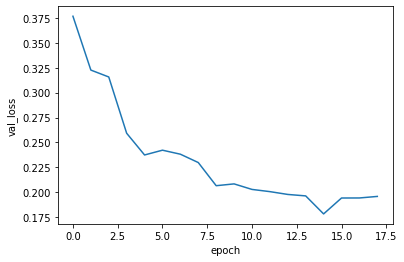

In [ ]:
import seaborn as sns

sns.lineplot(data = history_df, x='epoch', y = 'val_loss')

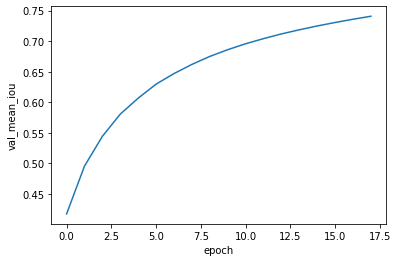

In [ ]:
sns.lineplot(data = history_df, x='epoch', y = 'val_mean_iou')

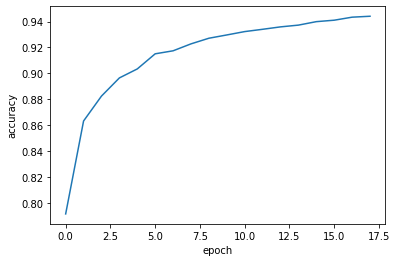

In [ ]:
sns.lineplot(data = history_df, x='epoch', y = 'accuracy')

## Predictions

Now we can load the model without having to retrain it!!!

In [ ]:
# Load Model
unet_model = load_model('salty_unet_model_contrasted_channel.h5')

prob_threshold = .5

Below needs to be cleaned up quite a bit. I havent' done anything yet with the real 18000 test images

In [ ]:
# Predict on train, val and test

# preds_train = unet_model.predict(X_train, verbose=1)
preds_val = unet_model.predict(X_test_channel, verbose=1)
# preds_test = unet_model.predict(X_test, verbose=1)

# Threshold predictions
# preds_train_t = (preds_train > prob_threshold).astype(np.uint8)
preds_val_t = (preds_val > prob_threshold).astype(np.uint8)
# preds_test_t = (preds_test > prob_threshold).astype(np.uint8)

16/16 [==============================] - 3s 173ms/step


In [ ]:
preds_val_t.shape

(500, 128, 128, 1)

Need to figure out how to make this prettier

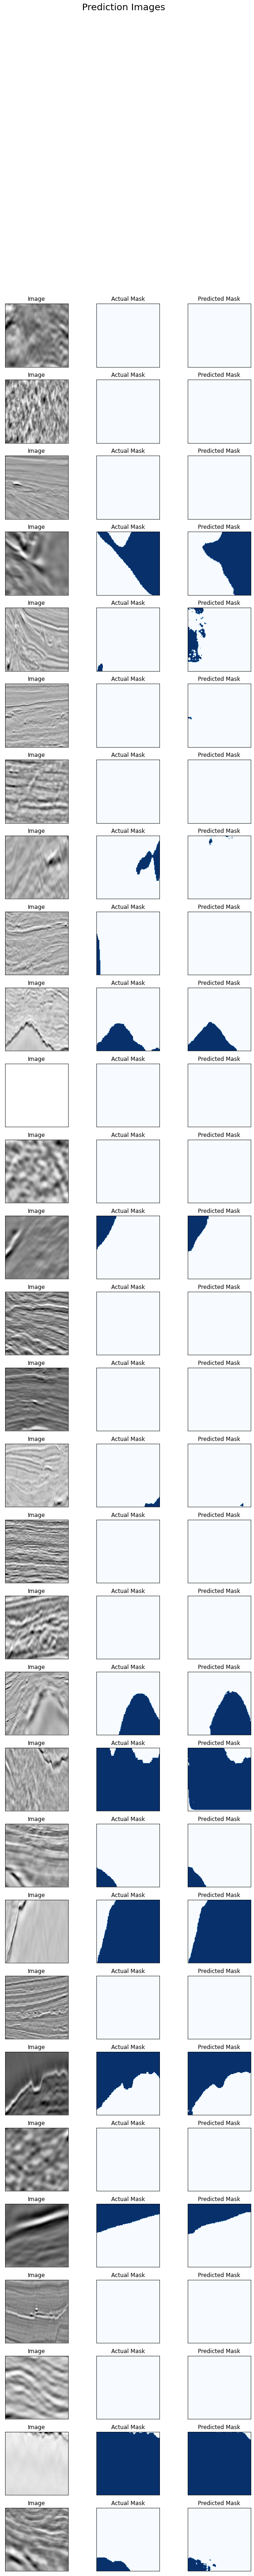

In [ ]:
imgs_to_show = 30
num_rows = imgs_to_show; num_cols = 3

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols,  figsize=(10, 3*imgs_to_show))

for i in range(imgs_to_show):
    ax = axs[i,0]
    ax.imshow(X_test[i],cmap='Greys')
    ax.title.set_text(f'Image')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ax = axs[i,1]
    ax.imshow(Y_test[i],cmap='Blues')
    ax.title.set_text(f'Actual Mask')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    ax = axs[i,2]
    ax.imshow(preds_val_t[i],cmap='Blues')
    ax.title.set_text(f'Predicted Mask')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


plt.suptitle('Prediction Images',fontsize=20);